**New updates:**

**1. Sobel derivatives from OpenCV2:**

We use this new edge detection methods provided by OpenCV to find a more optimized gradct instead of defined formula from ASSD paper. Hence, it can help improve the precision of the algorithm.

**2. 3D Pertubation:**

We take into consideration z direction from all ROI slices. We did that by calculating i0 as the minimum of the average gradct from the ROI voxels across all slices, and then used this i0 to find the truncated Guassian function (TG) for coutoring purpose. 

**3. Symmetry option:**

We also include the symmetry option in the improved algorithm by adjusting i0 and TG function.

## Loading data:

In [1]:
from dicom_utils import main
import numpy as np 
import pandas as pd 
import os
import pydicom
import matplotlib.pyplot as plt
import assd_func as af
from skimage import morphology

In [2]:
# Folder has to be in format "Subject_ID -> CT and RTSTRUCT (all captial)"
dicom_dir = "C:\\Users\\lykha\\OneDrive\\Documents\\Medical-imaging-Research\\Data\\Prostate Cases\\1\\"
output_dir = "C:\\Users\\lykha\\OneDrive\\Documents\\1_PhD_Fall_2020\\Research_MDA\\contour_segmentation\\Output\\"
images, slices, contours, labels, dummy_mask = main(dicom_dir, output_dir)

In [3]:
labels.shape

(186, 512, 512, 25)

Labels has 25 rois which stands for different organs to select

Let's print out the list of rois

In [4]:
contour_table = pd.DataFrame()
number = []
name = []
for i in range(24):
    number.append(contours[i]["number"])
    name.append(contours[i]["name"])
#contour_table["number"] = number
contour_table["name"] = name

In [5]:
contour_table

,name
0,marked iso
1,a prostate
2,b SV
3,PTV
4,d rectum
5,e bladder
6,f Femural Heads
7,g nt avoid
8,fiducials
9,p ring


Find location of the contour where labels == 1 (prostate)

In [6]:
a = np.argwhere(labels==True)
a[a[..., 3] == 1][0]

array([ 63, 246, 245,   1], dtype=int64)

Let's try slice 63 and so on

(-0.5, 511.5, 511.5, -0.5)

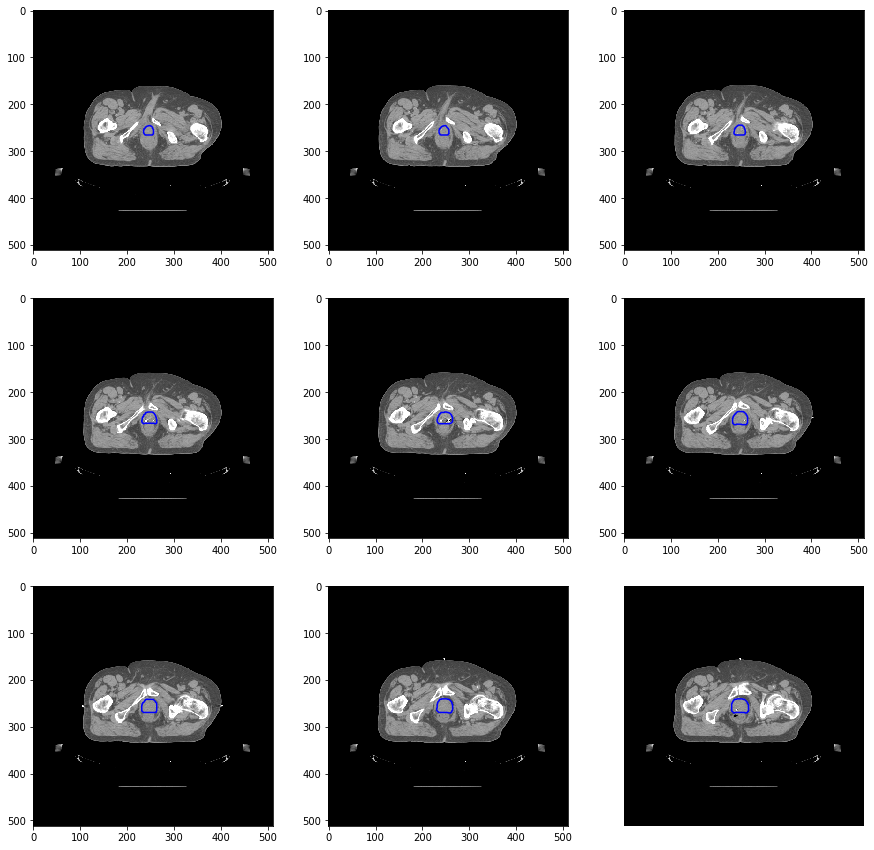

In [7]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i + 63, ...], cmap="gray", vmin=-250, vmax=250)
    plt.contour(labels[..., 1][i + 63, ...], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
plt.axis('off')

## 2. Sobel gradct and 3D Pertubation:

## 2.1 Testing on 1 slice

In [8]:
target_img1 = images[75, ...]
target_label1 = labels[..., 1][75, ...]

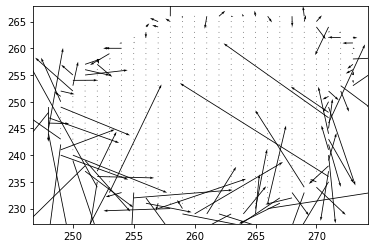

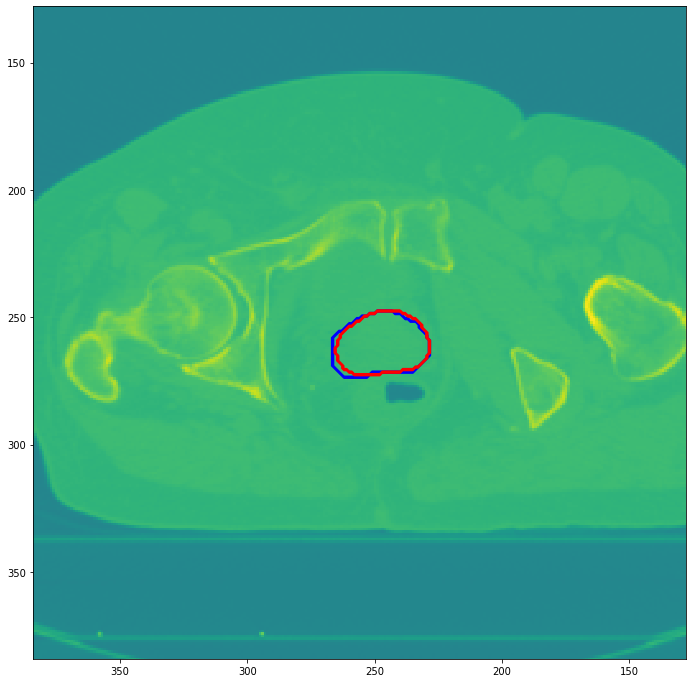

In [9]:
import assd_func_Sobel_sym as af_Sobel
# roi = target_label*target_img
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 20
SD=[c*1.7, c*2, c*2.5]
w = 2
k = 45
circles = 3
organ_i = 1
seed=123
dx, dy, mask, t, L, roi_z = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
du_1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=True, plot=True, display=True)
du_1 = np.where(du_1 < 0.5, 0, 4)

## 2.2 Testing on different views

In [12]:
frontal_target_img = images[0:100, 250, 0:512]
frontal_target_label = labels[..., 1][0:100, 250, 0:512]

In [13]:
dx, dy, mask, t, L, roi_z_frontal = af_Sobel.assd_Sobel(frontal_target_img, frontal_target_label, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
frontal_du = af_Sobel.plotting_assd(dx, dy, mask, frontal_target_img, quiver=False, plot=False, display=False)
frontal_du = np.where(frontal_du < 0.5, 0, 4)

In [14]:
sagittal_target_img = images[0:90, 0:512, 260]
sagittal_target_label = labels[..., 1][0:90, 0:512, 260]

In [15]:
dx, dy, mask, t, L, roi_z_sagital = af_Sobel.assd_Sobel(sagittal_target_img, sagittal_target_label, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
sagittal_du = af_Sobel.plotting_assd(dx, dy, mask, sagittal_target_img, quiver=False, plot=False, display=False)
sagittal_du = np.where(sagittal_du < 0.5, 0, 4)

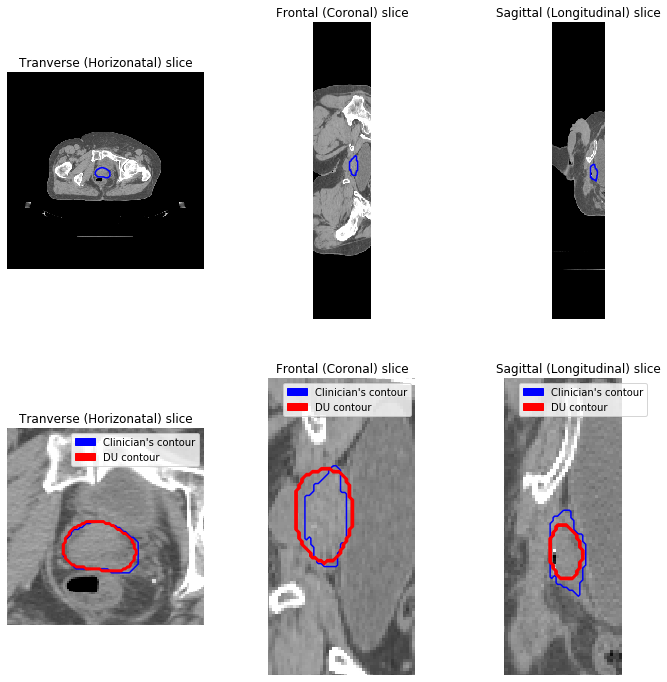

In [16]:
import matplotlib.patches as mpatches

blue_patch = mpatches.Patch(color='blue', label="Clinician's contour")
red_patch = mpatches.Patch(color='red', label='DU contour')


fig, ax = plt.subplots(2, 3, figsize=[12, 12])

ax[0, 0].set_title("Tranverse (Horizonatal) slice")
ax[0, 0].imshow(target_img1, cmap='gray', vmin=-250, vmax=250)
ax[0, 0].contour(target_label1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[0, 0].set_xlabel("Orginal contour")
ax[0, 0].axis('off')

ax[0, 1].set_title("Frontal (Coronal) slice")
ax[0, 1].imshow(frontal_target_img.transpose(), cmap='gray', vmin=-250, vmax=250)
ax[0, 1].contour(frontal_target_label.transpose(), levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[0, 1].set_xlabel("Orginal contour")
ax[0, 1].axis('off')

ax[0, 2].set_title("Sagittal (Longitudinal) slice")
ax[0, 2].imshow(sagittal_target_img.transpose(), cmap='gray', vmin=-250, vmax=250)
ax[0, 2].contour(sagittal_target_label.transpose(), levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[0, 2].set_xlabel("Orginal contour")
ax[0, 2].axis('off')

ax[1, 0].set_title("Tranverse (Horizonatal) slice")
ax[1, 0].imshow(target_img1, cmap='gray', vmin=-250, vmax=250)
ax[1, 0].contour(target_label1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[1, 0].contour(du_1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='red')
ax[1, 0].set_xlabel("DU contour")
ax[1, 0].set_xlim(200, 300)
ax[1, 0].set_ylim(300, 200)
ax[1, 0].legend(handles=[ blue_patch, red_patch])
ax[1, 0].axis('off')

ax[1, 1].set_title("Frontal (Coronal) slice")
ax[1, 1].imshow(frontal_target_img.transpose(), cmap='gray', vmin=-250, vmax=250)
ax[1, 1].contour(frontal_target_label.transpose(), levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[1, 1].contour(frontal_du.transpose(), levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='red')
ax[1, 1].set_xlabel("DU contour")
ax[1, 1].set_xlim(50, 100)
ax[1, 1].set_ylim(300, 200)
ax[1, 1].legend(handles=[ blue_patch, red_patch])
ax[1, 1].axis('off')

ax[1, 2].set_title("Sagittal (Longitudinal) slice")
ax[1, 2].imshow(sagittal_target_img.transpose(), cmap='gray', vmin=-250, vmax=250)
ax[1, 2].contour(sagittal_target_label.transpose(), levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[1, 2].contour(sagittal_du.transpose(), levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='red')
ax[1, 2].set_xlabel("DU contour")
ax[1, 2].set_xlim(50, 100)
ax[1, 2].set_ylim(300, 200)
ax[1, 2].legend(handles=[ blue_patch, red_patch])
ax[1, 2].axis('off')

plt.show()

## 2.3 Testing on different slices

In [17]:
assd_contour = []

for i in range(12):
    if i != 7:
        dx, dy, mask, t, L, roi_z  = af_Sobel.assd_Sobel(images[65 + i, ...], labels[..., 1][65 + i, ...], voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
        du = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
        du_2 = np.where(du < 0.5, 0, 4)
        assd_contour.append(list(du_2)) #surface
assd_contour = np.array(assd_contour)


(200.0, 300.0, 300.0, 200.0)

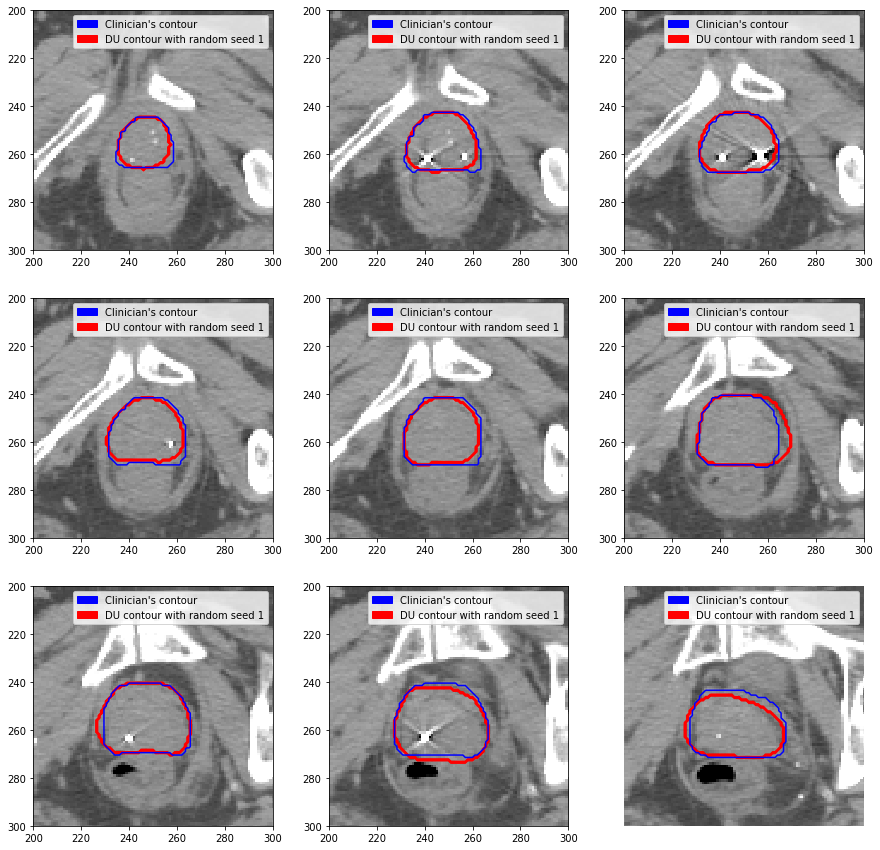

In [18]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[65 + i , ...], cmap="gray", vmin=-250, vmax=250)
    plt.contour(assd_contour[i, ...], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.contour(labels[..., 1][65 + i, ...], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
    plt.xlim(200, 300)
    plt.ylim(300, 200)
    blue_patch = mpatches.Patch(color='blue', label="Clinician's contour")
    red_patch = mpatches.Patch(color='red', label='DU contour with random seed 1')
    plt.legend(handles=[ blue_patch, red_patch])
    
plt.axis('off')

In [19]:
assd_contour = []
seed = 456
for i in range(12):
    if i != 7:
        dx, dy, mask, t, L, roi_z  = af_Sobel.assd_Sobel(images[65 + i, ...], labels[..., 1][65 + i, ...], voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
        du = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
        du_2 = np.where(du < 0.5, 0, 4)
        assd_contour.append(list(du_2)) #surface
assd_contour = np.array(assd_contour)

(200.0, 300.0, 300.0, 200.0)

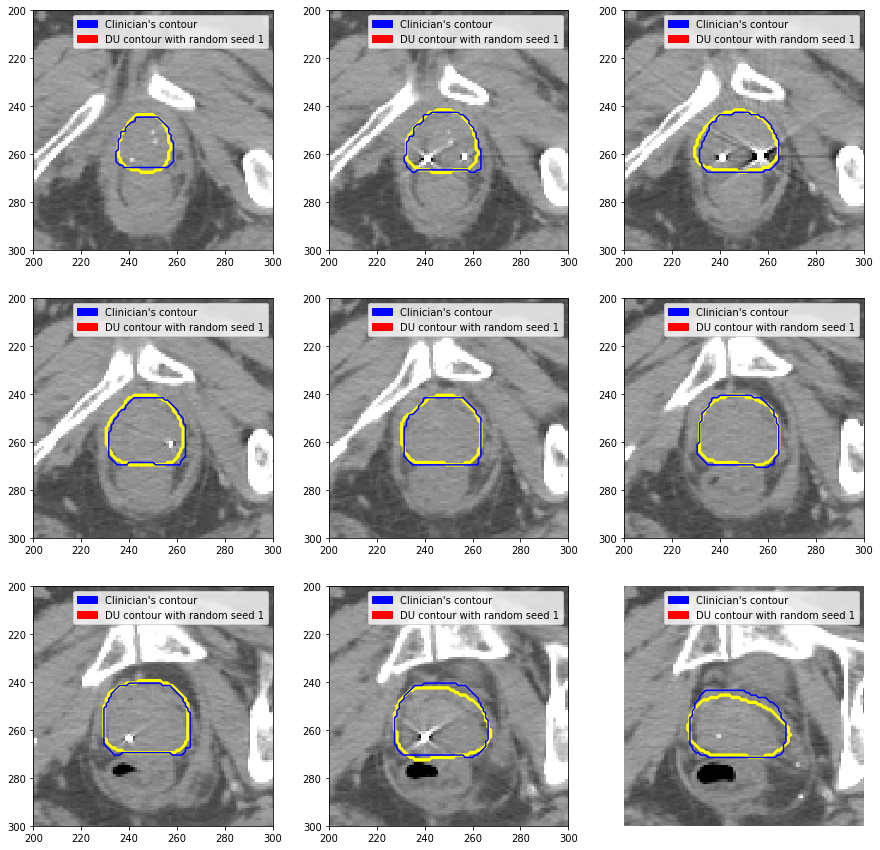

In [20]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[65 + i , ...], cmap="gray", vmin=-250, vmax=250)
    plt.contour(assd_contour[i, ...], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="yellow")
    plt.contour(labels[..., 1][65 + i, ...], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
    plt.xlim(200, 300)
    plt.ylim(300, 200)
    blue_patch = mpatches.Patch(color='blue', label="Clinician's contour")
    red_patch = mpatches.Patch(color='red', label='DU contour with random seed 1')
    plt.legend(handles=[ blue_patch, red_patch])
    
plt.axis('off')

## 3. Symmetry option:

In [7]:
target_img2 = images[70, ...]
target_label2 = labels[..., 1][70, ...]

## x-symmetry on 1 slide

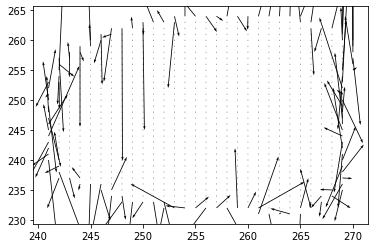

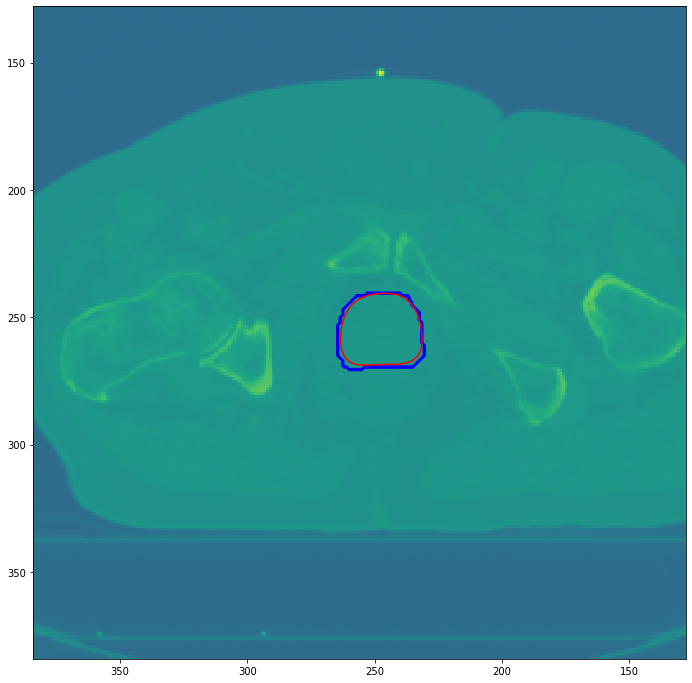

In [16]:
import assd_func_Sobel_sym_2 as af_Sobel_2
# roi = target_label*target_img
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 20
SD=[c*1.7, c*2, c*2.5]
w = 2
k = 45
circles = 3
organ_i = 1
seed=123
sym="y-axis"
dx, dy, mask, t, L = af_Sobel_2.assd_sym(target_img2, target_label2, voxelsize, a, SD, circles, seed, k, w, sym, images, labels, 1, smooth=True)
sym_y_du = af_Sobel_2.plotting_assd(dx, dy, mask, target_img2, quiver=True, plot=True, display=True)
du_1 = np.where(sym_y_du < 0.5, 0, 4)


## y-symmetry on 1 slide

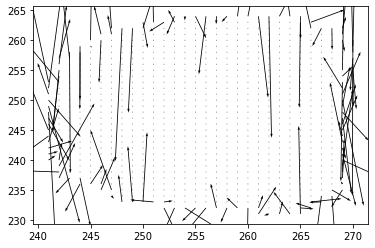

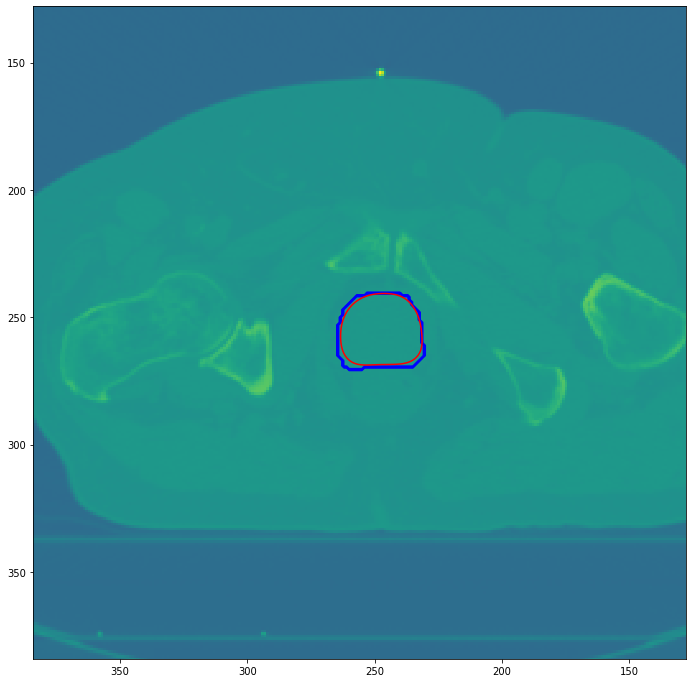

In [17]:
import assd_func_Sobel_sym_2 as af_Sobel_2
# roi = target_label*target_img
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 25
SD=[c*1.7, c*2, c*2.5]
w = 2
k = 45
circles = 3
organ_i = 1
seed=123
sym="x-axis"
dx, dy, mask, t, L = af_Sobel_2.assd_sym(target_img2, target_label2, voxelsize, a, SD, circles, seed, k, w, sym, images, labels, 1, smooth=True)
sym_y_du = af_Sobel_2.plotting_assd(dx, dy, mask, target_img2, quiver=True, plot=True, display=True)
du_1 = np.where(sym_y_du < 0.5, 0, 4)

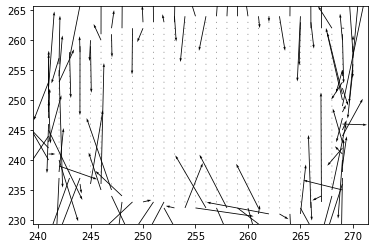

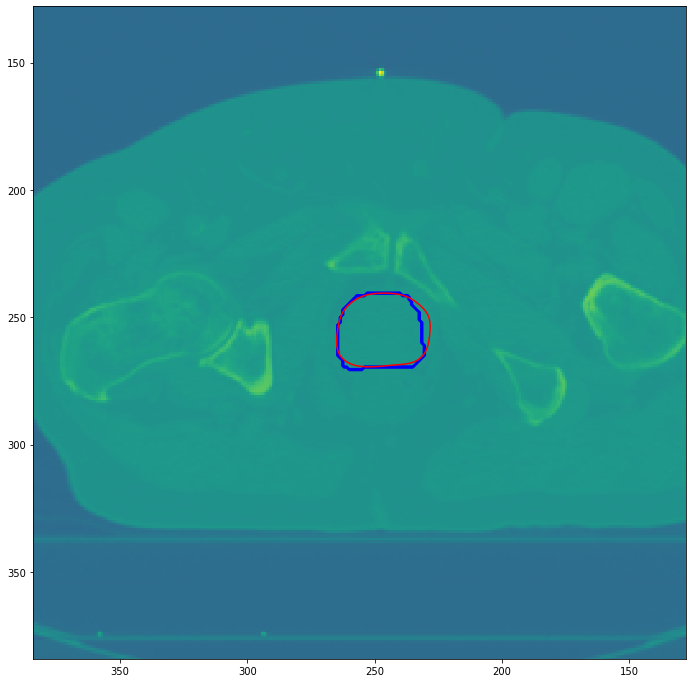

In [62]:
import assd_func_Sobel_sym_2 as af_Sobel_2
# roi = target_label*target_img
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 100
SD=[c*1.7, c*2, c*2.5]
w = 2
k = 15
circles = 3
organ_i = 1
seed=123
sym="x-axis"
dx, dy, mask, t, L = af_Sobel_2.assd_sym(target_img2, target_label2, voxelsize, a, SD, circles, seed, k, w, sym, images, labels, 1, smooth=True)
sym_y_du = af_Sobel_2.plotting_assd(dx, dy, mask, target_img2, quiver=True, plot=True, display=True)
du_1 = np.where(sym_y_du < 0.5, 0, 4)

In [58]:
assd_contour = []

for i in range(12):
    if i != 7:
        sym="y-axis"
        dx, dy, mask, t, L  = af_Sobel_2.assd_sym(images[65 + i, ...], labels[..., 1][65 + i, ...], voxelsize, a, SD, circles, seed, k, w, sym, images, labels, 1, smooth=True)
        du = af_Sobel.plotting_assd(dx, dy, mask, images[63 + i, ...], quiver=False, plot=False)
        du_2 = np.where(du < 0.5, 0, 4)
        assd_contour.append(list(du_2)) #surface
assd_contour = np.array(assd_contour)


C:\Users\lykha\OneDrive\Documents\1_PhD_Fall_2020\Research_MDA\contour_segmentation\assd_func_Sobel_sym_2.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  m = (L[i0][1]-cY)/(L[i0][0]-cX)
C:\Users\lykha\OneDrive\Documents\1_PhD_Fall_2020\Research_MDA\contour_segmentation\assd_func_Sobel_sym_2.py:207: RuntimeWarning: divide by zero encountered in double_scalars
  new_m =abs((L[i,1]-cY)/(L[i,0]-cX) + m)


(200.0, 300.0, 300.0, 200.0)

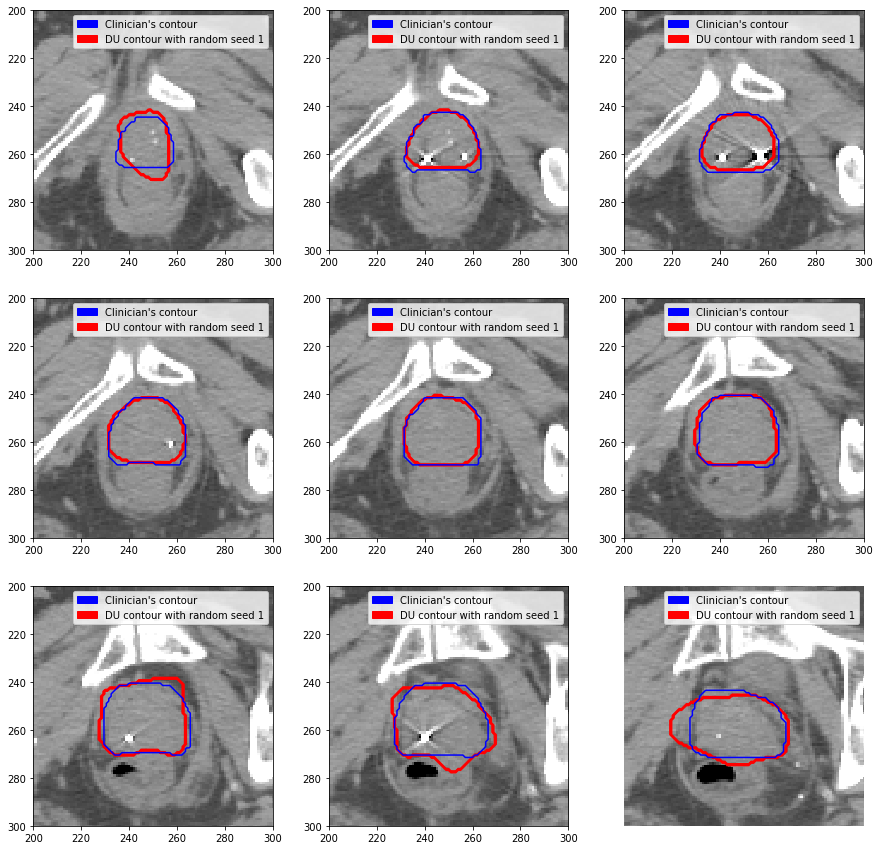

In [59]:
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[65 + i , ...], cmap="gray", vmin=-250, vmax=250)
    plt.contour(assd_contour[i, ...], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.contour(labels[..., 1][65 + i, ...], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
    plt.xlim(200, 300)
    plt.ylim(300, 200)
    blue_patch = mpatches.Patch(color='blue', label="Clinician's contour")
    red_patch = mpatches.Patch(color='red', label='DU contour with random seed 1')
    plt.legend(handles=[ blue_patch, red_patch])
    
plt.axis('off')

## 4 Discussion:

1. New implementations of Sobel gradct and 3D pertubation seems to work well and create consistent contour accross different slices. Best set of parameters are SD = 20*[1.7, 2, 2.5], and k = 45.
2. Symmetry option seems to oversmooth and a bit of paramaters. However, the symmetry doesn't seem to be neccessary now with the new implementation of Sobel gradct and 3D pertubation takes care of the inconsistency and unsymmetrical that we saw in previous presentation
3. What needs to be prepared for clinician's review. 
4. What should we call the new algorithm since a lot of new improvements have been implemented outside of the original ASSD algorithm?